In [1]:
import json
import re
import time
import numpy
import gensim
import gensim.models.word2vec as w2v
###导入genism模块进行词向量的训练处理###
###其中w2v是用于词的分类和定义的模块，为外部导入的相关内容###
from gensim.corpora.dictionary import Dictionary
import jieba
###导入jieba模块进行分词的处理###
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.utils.data as Data
import torch
###导入torch.nn模块便于直接调用###
import numpy as np
import random
from IPython import display
from matplotlib import pyplot as plt
from torchvision.datasets import MNIST
from torch import nn
import torch.utils.data as Data
import torch.optim as optim
from torch.nn import init
###导入画图相关函数与画图函数等相关内容###
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
####定义多分类的三个评价指标函数####
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from sklearn.metrics import f1_score

In [2]:
def clean(data):
    
    data_out = []
    
    # 清洗数据
    for temp in data:
        temp_json = json.loads(temp)
        # 数据清洗
        temp_json['content'] = re.sub(r'\/\/\@.*?(\：|\:)', "", temp_json['content']) # 清除@用户信息
        temp_json['content'] = re.sub(r'\#.*?\#', "", temp_json['content']) # 清除话题信息
        temp_json['content'] = re.sub(r'\【.*?\】', "", temp_json['content']) # 清除话题信息
        temp_json['content'] = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', "", temp_json['content'], flags=re.MULTILINE) # 清除链接信息
        #对前部分数据进行初步的处理，排除不相干信息，详情可以参考CSDN
        # 转化label
        if(temp_json['label']=='neural'):
            temp_json['label'] = 0
        elif(temp_json['label']=='happy'):
            temp_json['label'] = 1
        elif(temp_json['label']=='angry'):
            temp_json['label'] = 2
        elif(temp_json['label']=='sad'):
            temp_json['label'] = 3
        elif(temp_json['label']=='fear'):
            temp_json['label'] = 4
        elif(temp_json['label']=='surprise'):
            temp_json['label'] = 5
        #对数据集进行初步分类，给不同的情绪不同的标签
        data_out.append(temp_json)
        
    return data_out

In [3]:
def load_deal_data(path):
    # 根据路径加载数据
    file = open('virus_train.txt', 'r',encoding = 'utf-8')
    string_raw = file.read()
    file.close()
    
    pattern = re.compile(r'{.+?}')   # 正则表达式，匹配字典
    data_load = pattern.findall(string_raw) 
    data_raw = clean(data_load) 
    return data_raw

data_raw_train = load_deal_data('virus_train.txt')#训练数据集，要用virus_train数据集
data_raw_test = load_deal_data('virus_eval_labeled.txt')#测试数据集，要用virus_eval_labeled数据集

In [4]:
def splite_content(data):    
    string_splite = ''
    pure_data = []
    for temp in range(len(data)):
        content = data[temp]['content']
        new_content = jieba.cut(content,cut_all=False)
        str_out = ' '.join(new_content)
        cop = re.compile("[^\u4e00-\u9fa5^a-z^A-Z^0-9^\s]") # 去除不相关的字符等相关内容
        str_out = cop.sub('', str_out)

        for i in range(6):
            str_out = str_out.replace('  ',' ') # 去除多余空格
        str_out = str_out.strip() # 去除两边空格

        data[temp]['content'] = str_out.split(' ')
        pure_data.append([data[temp]['content'],data[temp]['label']])
        str_out += '\r\n' 
        string_splite += str_out
    return pure_data, string_splite

splite_word_all = '' # 分词总文本(包括训练文本和测试文本)
data_seg_train, out = splite_content(data_raw_train)
splite_word_all += out 
data_seg_test, out = splite_content(data_raw_test)
splite_word_all += out 

# 保存分好词的文本
f = open('splite_word_all.txt', 'w', encoding='utf-8')
f.write(splite_word_all)
f.close()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\20693\AppData\Local\Temp\jieba.cache
Loading model cost 0.608 seconds.
Prefix dict has been built successfully.


全部数据词总数为： 169884 ; 每条数据的平均词数为： 19.740181268882175


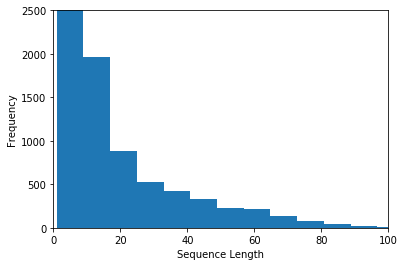

In [5]:
def analyse_word_num(data):
    data_num_train = len(data) # 数据条数
    word_num = 0 # 总词数
    single_num = [] # 每条数据的长度的大小数组
    ave_num = 0 # 平均每条数据的词数大小

    for i in range(len(data)):
        single_num.append(len(data[i][0]))
        word_num += len(data[i][0])
    ave_num = word_num/data_num_train
    print('全部数据词总数为：',word_num,'; 每条数据的平均词数为：' ,ave_num)
    #对输出内容进行统一化格式管理
    %matplotlib inline
    plt.hist(single_num, bins=200)
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.axis([0,100,0,2500])#定义坐标轴范围等相关内容
    plt.show()
    
analyse_word_num(data_seg_train)

In [6]:
#模型训练，生成词向量
model_file_name = 'model.txt'
sentences = w2v.LineSentence('splite_word_all.txt')
model = w2v.Word2Vec(sentences, size=30, window=20, min_count=5, workers=8) # 参数含义：数据源，生成词向量长度，时间窗大小，最小词频数，线程数
model.save(model_file_name)

# 使用训练好的模型
model = w2v.Word2Vec.load(model_file_name)

# 寻找与几个相近词语
for k in model.similar_by_word('随便'):
    print(k[0],k[1])
print("************间隔行***********")      
for k in model.similar_by_word('开心'):
    print(k[0],k[1])
print("************间隔行***********")
for k in model.similar_by_word('愤怒'):
    print(k[0],k[1])
print("************间隔行***********")
for k in model.similar_by_word('伤心'):
    print(k[0],k[1])
print("************间隔行***********")      
for k in model.similar_by_word('害怕'):
    print(k[0],k[1])
print("************间隔行***********")
for k in model.similar_by_word('吃惊'):
    print(k[0],k[1])
print("************间隔行***********")

# 创建词语字典
def create_dictionaries(p_model):
    gensim_dict = Dictionary()
    gensim_dict.doc2bow(p_model.wv.index2word, allow_update=True)
    w2indx = {v: k  for k, v in gensim_dict.items()}  # 词语的索引，从0开始编号
    id2vec = {w2indx.get(word): model.wv.__getitem__(word) for word in w2indx.keys()}  # 词语的词向量
    return w2indx, id2vec
#创建相关的词典

word_id_dic, id_vect_dic= create_dictionaries(model) # 两个词典的功能：word-> id , id -> vector
print('失望对应的id为：',word_id_dic['随便'])
print('失望对应的词向量vector为：',id_vect_dic[word_id_dic['随便']])
print('开心对应的id为：',word_id_dic['开心'])
print('开心对应的词向量vector为：',id_vect_dic[word_id_dic['开心']])
print('愤怒对应的id为：',word_id_dic['愤怒'])
print('愤怒对应的词向量vector为：',id_vect_dic[word_id_dic['愤怒']])
print('伤心对应的id为：',word_id_dic['伤心'])
print('伤心对应的词向量vector为：',id_vect_dic[word_id_dic['伤心']])
print('害怕对应的id为：',word_id_dic['害怕'])
print('害怕对应的词向量vector为：',id_vect_dic[word_id_dic['害怕']])
print('吃惊对应的id为：',word_id_dic['吃惊'])
print('吃惊对应的词向量vector为：',id_vect_dic[word_id_dic['吃惊']])

人能 0.9348695278167725
基本上 0.9295836091041565
敢 0.9180195331573486
女演员 0.9156574010848999
tmd 0.9147307872772217
不负责任 0.9118232131004333
电视剧 0.9088055491447449
过分 0.907978892326355
我服 0.9074898958206177
速度 0.9064911007881165
************间隔行***********
抓狂 0.9124795198440552
哼 0.9084577560424805
可爱 0.9064897894859314
哈哈 0.9028811454772949
吃完饭 0.9012061357498169
笑 0.8948900699615479
耶 0.8931143283843994
要赞 0.8863654732704163
委屈 0.880510687828064
黑线 0.8799939155578613
************间隔行***********
质疑 0.9351482391357422
老百姓 0.932889461517334
深刻 0.9313604235649109
却是 0.9262279868125916
如此 0.9148024320602417
每一件 0.9135828614234924
一点点 0.9110497832298279
灾难 0.9065529108047485
看不到 0.9010790586471558
核心 0.9006522297859192
************间隔行***********
过来 0.9461280703544617
评论 0.9391739368438721
操 0.9336980581283569
量 0.9280046224594116
眼神 0.9241760969161987
删 0.9232779741287231
tm 0.9167527556419373
简直 0.9161972403526306
刷 0.9159523248672485
我见 0.9155175089836121
************间隔行***********
我怕 0.9183127

D:\Anoconda\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  # This is added back by InteractiveShellApp.init_path()
D:\Anoconda\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
D:\Anoconda\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
D:\Anoconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
D:\Anoconda\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
D:\A

In [7]:
# token化数据，word->id
def get_tokenized_imdb(data):
    """
    data: list of [list of word , label]
    
    """
    for word_list, label in data:
        temp = []
        for word in word_list:
            if(word in word_id_dic.keys()):
                temp.append(int(word_id_dic[word]))
            else:
                temp.append(0)
        yield [temp,label]
#把文本转换为字符串数据，tokenization，它按照特定需求，把文本切分成一个字符串序列

In [8]:
# 对数据进行截断和补充，补充成完整的数据串
def preprocess_imdb(data):
    max_l = 30  # 将每条微博通过截断或者补1，使得长度变成30

    def pad(x):
        return x[:max_l] if len(x) > max_l else x + [1] * (max_l - len(x))

    features = torch.tensor([pad(content[0]) for content in data])
    labels = torch.tensor([score for _, score in data])
    return features, labels

data_train = preprocess_imdb(list(get_tokenized_imdb(data_seg_train)))
data_test = preprocess_imdb(list(get_tokenized_imdb(data_seg_test)))

# 加载数据到迭代器，并规定batch 大小
batch_size = 32
train_set = Data.TensorDataset(*data_train)  # *表示接受元组类型数组
train_iter = Data.DataLoader(train_set, batch_size, shuffle=True)
test_set = Data.TensorDataset(*data_test)  # *表示接受元组类型数组
test_iter = Data.DataLoader(test_set, batch_size, shuffle=True)#注意，测试集数据不能用训练集数据替代

In [9]:
class BiRNN(nn.Module):
    def __init__(self, vocab_num, embed_size, num_hiddens, num_layers):
        super(BiRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_num, embed_size)
        # bidirectional设为True即得到双向循环神经网络
        self.encoder = nn.LSTM(input_size=embed_size, 
                                hidden_size=num_hiddens, 
                                num_layers=num_layers,
                                bidirectional=True)
        # 初始时间步和最终时间步的隐藏状态作为全连接层输入
        self.decoder = nn.Linear(4*num_hiddens, 6)

    def forward(self, inputs):
        # inputs的形状是(批量大小, 词数)，因为LSTM需要将序列长度(seq_len)作为第一维，所以将输入转置后
        # 再提取词特征，输出形状为(词数, 批量大小, 词向量维度)
        embeddings = self.embedding(inputs.permute(1, 0))
        # rnn.LSTM只传入输入embeddings，因此只返回最后一层的隐藏层在各时间步的隐藏状态。
        # outputs形状是(词数, 批量大小, 2 * 隐藏单元个数)
        outputs, _ = self.encoder(embeddings) # output, (h, c)
        # 连结初始时间步和最终时间步的隐藏状态作为全连接层输入。它的形状为
        # (批量大小, 4 * 隐藏单元个数)。
        encoding = torch.cat((outputs[0], outputs[-1]), -1)
        outs = self.decoder(encoding)
        return outs
vocab_num = len(model.wv.index2word)
embed_size, num_hiddens, num_layers = 30, 120, 4
net = BiRNN(vocab_num, embed_size, num_hiddens, num_layers)

In [10]:
id_vect = torch.Tensor(list(id_vect_dic.values()))
net.embedding.weight.data.copy_(id_vect)
net.embedding.weight.requires_grad = False # 直接加载预训练好的, 所以不需要更新它

In [11]:
lr, num_epochs = 0.001, 60
# 定义学习率和迭代次数
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
loss = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# 训练函数
def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    p_ls,re_ls,f1_ls=[],[],[]
    for epoch in range(num_epochs):
        train1,train2,train3,train_l_sum, start = 0.0,0.0,0.0,0.0,  time.time()
        batch_count = 0
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            y1 = y_hat.detach().cpu().numpy()   ###########
            y1 = np.argmax(y1, axis = 1)
            y2 = y.detach().cpu().numpy()
            train1 += precision_score(y1, y2, average='macro')
            train2 += recall_score(y1, y2, average='macro')
            train3 += f1_score(y1, y2, average='macro')
            batch_count += 1
            
        test_acc = evaluate_accuracy(test_iter, net)   
        p_ls.append(train1/batch_count)
        re_ls.append(train2/batch_count)
        f1_ls.append(train3/batch_count)   
        
        if((epoch+1)%1 == 0):
            print('epoch %d, precision %.3f,recall %.3f,f1 %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1,train1/batch_count,train2/batch_count,train3/batch_count, test_acc, time.time() - start)) 
    loss_plot(range(1, num_epochs + 1), p_ls, 'epochs', 'p_ls',['train', 'test'])
    loss_plot(range(1, num_epochs + 1), re_ls, 'epochs', 're_ls', ['train', 'test'])
    loss_plot(range(1, num_epochs + 1), f1_ls, 'epochs', 'f1_ls', ['train', 'test'])

In [13]:
# 评价函数
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device 
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: # 自定义的模型, 3.13节之后不会用到, 不考虑GPU
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n

In [14]:
# 定义绘图函数
def loss_plot(x_vals, y_vals, x_label, y_label, 
              legend,figsize=(3.5, 2.5)):          #x2_vals=None, y2_vals=None,
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x_vals, y_vals,label=y_label)
    plt.legend()
    
''' if x2_vals and y2_vals:
        plt.plot(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)'''

" if x2_vals and y2_vals:\n        plt.plot(x2_vals, y2_vals, linestyle=':')\n        plt.legend(legend)"

training on  cpu


D:\Anoconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anoconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 1, precision 0.402,recall 0.341,f1 0.347, test acc 0.668, time 157.0 sec
epoch 2, precision 0.471,recall 0.448,f1 0.436, test acc 0.678, time 134.7 sec
epoch 3, precision 0.492,recall 0.481,f1 0.459, test acc 0.692, time 127.6 sec
epoch 4, precision 0.500,recall 0.487,f1 0.469, test acc 0.714, time 122.8 sec
epoch 5, precision 0.520,recall 0.512,f1 0.488, test acc 0.714, time 125.8 sec
epoch 6, precision 0.515,recall 0.511,f1 0.488, test acc 0.721, time 123.1 sec
epoch 7, precision 0.537,recall 0.527,f1 0.507, test acc 0.731, time 121.3 sec
epoch 8, precision 0.550,recall 0.537,f1 0.520, test acc 0.744, time 121.8 sec
epoch 9, precision 0.566,recall 0.566,f1 0.541, test acc 0.762, time 127.5 sec
epoch 10, precision 0.579,recall 0.580,f1 0.554, test acc 0.776, time 129.3 sec
epoch 11, precision 0.604,recall 0.599,f1 0.578, test acc 0.790, time 125.9 sec
epoch 12, precision 0.627,recall 0.631,f1 0.602, test acc 0.804, time 129.5 sec
epoch 13, precision 0.653,recall 0.655,f1 0.630, 

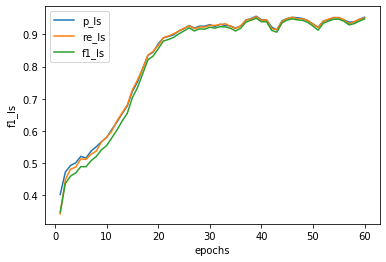

In [15]:
train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)